In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [ ]:
raw_data = pd.read_csv("car_insurance_claim.csv")

In [4]:
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


#   DATA CLEANING

In [5]:
data_df = raw_data.copy()

We have just created a copy of our actual data and changed the column names to little descriptive names.

In [6]:
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df.rename(columns=col_names, inplace=True)

In [7]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10301 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10301 non-null  int64  
 1   num_young_drivers          10301 non-null  int64  
 2   date_of_birth              10301 non-null  object 
 3   age                        10294 non-null  float64
 4   num_of_children            10301 non-null  int64  
 5   years_job_held_for         9753 non-null   float64
 6   income                     9731 non-null   object 
 7   single_parent              10301 non-null  object 
 8   value_of_home              9726 non-null   object 
 9   married                    10301 non-null  object 
 10  gender                     10301 non-null  object 
 11  highest_education          10301 non-null  object 
 12  occupation                 9636 non-null   object 
 13  commute_dist               10301 non-null  int

We have observed that some columns like income includes special characters like "$" and ",". We need to change that to change the column type to Integer

In [9]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10301 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10301 non-null  int64  
 1   num_young_drivers          10301 non-null  int64  
 2   date_of_birth              10301 non-null  object 
 3   age                        10294 non-null  float64
 4   num_of_children            10301 non-null  int64  
 5   years_job_held_for         9753 non-null   float64
 6   income                     9731 non-null   Int64  
 7   single_parent              10301 non-null  object 
 8   value_of_home              9726 non-null   Int64  
 9   married                    10301 non-null  object 
 10  gender                     10301 non-null  object 
 11  highest_education          10301 non-null  object 
 12  occupation                 9636 non-null   object 
 13  commute_dist               10301 non-null  int

As we can see that all the data types have changed to integers as we removed the special characters.

In [11]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

We need to remove this Z prefix data values from multiple columns as we can see in married, gender etc.

In [12]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

- ID is just a unique identifier so is not needed
- data_of_birth duplicates the age feature (as age infers this information) so is not needed

In [13]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


<AxesSubplot:xlabel='new_claim_value', ylabel='Count'>

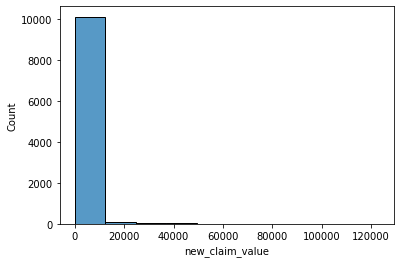

In [14]:
# Create hisogram for new claim value
sns.histplot(data_df['new_claim_value'], bins=10)

In [18]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<AxesSubplot:ylabel='claim_value_cat'>

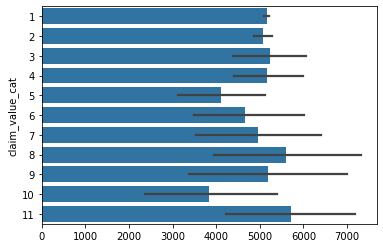

In [24]:
sns.barplot(data_df['claim_value_cat']) #ci=95)

# Explanation of the Barplot
Plot Description:

- The y-axis represents the Claim Value Categories (bins), numbered 1 through 11.
- The x-axis represents the average new_claim_value for each category.
- The bars show the mean value of new_claim_value within each bin.
- The lines on top of the bars are error bars, which represent the standard deviation (SD) of the claim values in each category.

By default, The error line in the Seaborn's sns.barplot() calculates and displays the 95% confidence interval (CI) for the mean of the data in each category. This interval is computed using bootstrapping or statistical formulas.
You do have an option to change ci to "sd" (if you want to see the spread of the values) and can also set as None or any other Confidence interval.
    
    If using a confidence interval:
    - The error bar shows the range within which the true population parameter (e.g., mean) lies with a certain confidence level, usually 95%.


Why Error Bars Matter?
    
- They add an extra layer of information about data variability.
- For instance, overlapping error bars between two categories might suggest no significant difference in their means.
- Wider error bars suggest more variability within the category, while narrower ones indicate consistent claim values.

In [25]:
# Create clean copy of training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the target feature
X.drop(columns=['new_claim_value','is_claim'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

By setting stratify to a target variable it ensures that the proportion of each class in the target variable is preserved in both the training and test sets. This helps prevent the model from being trained on a dataset that does not accurately represent the distribution of the classes in the real-world data.

In [26]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


Since we do not need the claim value category column from both the X_train and X_test. So we can eliminate both the columns

In [27]:
for set_ in (X_train, X_test):
    set_.drop(columns=['claim_value_cat'], inplace=True)

# EXPLANATORY DATA ANALYSIS

We can investigate correlation if we join X_train and y_train for the purpose of EDA

In [28]:
# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,No,0,No,F,<High School,Blue Collar,40,Private,7200,10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,No,109835,Yes,F,<High School,Blue Collar,24,Private,6530,4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,Yes,174139,No,M,<High School,Clerical,39,Private,1500,4,Minivan,no,5419,1,No,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,Yes,202178,No,F,Bachelors,Professional,18,Private,22260,1,Minivan,no,5290,1,No,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,No,312887,Yes,M,High School,Professional,25,Commercial,5400,1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban,0


For the purpose of the exploration, we will first update 'Yes/No' features to bonary so we can see how these correlate too. We'll also update gender to use binary values. 1 = male, 0 = female

In [29]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [30]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


We now build a correlation matrix as there are many features

In [34]:
numeric_df = eda_test_data.select_dtypes(include=['number'])

# Calculate the correlation
correlation_matrix = numeric_df.corr()

In [35]:
correlation_matrix

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,0.204141,-0.022470,0.037441,-0.041781,0.012918,-0.026245,-0.004106,-0.045062,0.035981,0.034724,0.040039,0.052874,-0.062621,0.109085
age,-0.076813,1.000000,-0.448207,0.134522,0.188711,-0.314111,0.205616,0.083260,0.075122,0.003201,0.172433,-0.004511,0.028833,-0.040818,-0.037820,-0.045184,-0.079780,0.176683,-0.107146
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,0.456293,-0.106974,0.037708,-0.114426,-0.000621,-0.109210,0.012882,-0.072370,0.049397,0.038404,0.051109,0.071365,-0.152561,0.128697
years_job_held_for,0.038082,0.134522,0.079570,1.000000,0.294414,-0.027043,0.266811,0.126541,0.080323,-0.008878,0.144719,0.023089,0.054180,-0.005708,-0.026019,-0.009085,-0.040719,0.053936,-0.053815
income,-0.046508,0.188711,-0.158150,0.294414,1.000000,-0.069598,0.571126,-0.038203,0.111590,-0.051479,0.426426,0.003469,0.061301,-0.049042,-0.044323,-0.031050,-0.065223,0.406856,-0.147085
single_parent,0.204141,-0.314111,0.456293,-0.027043,-0.069598,1.000000,-0.248240,-0.476495,-0.061451,-0.016323,-0.042579,0.009828,-0.039510,0.044080,0.060335,0.052374,0.074748,-0.063892,0.154323
value_of_home,-0.022470,0.205616,-0.106974,0.266811,0.571126,-0.248240,1.000000,0.456279,0.072382,-0.031111,0.257783,0.011225,0.027262,-0.067330,-0.092703,-0.048395,-0.097057,0.208012,-0.193881
married,0.037441,0.083260,0.037708,0.126541,-0.038203,-0.476495,0.456279,1.000000,-0.003163,0.007881,-0.016074,-0.001100,-0.018030,-0.043098,-0.070880,-0.039376,-0.050486,-0.036120,-0.132326
gender,-0.041781,0.075122,-0.114426,0.080323,0.111590,-0.061451,0.072382,-0.003163,1.000000,-0.007181,0.068276,-0.012598,0.664545,-0.009735,0.014060,-0.024676,-0.006218,0.026945,-0.021205
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,-0.016323,-0.031111,0.007881,-0.007181,1.000000,-0.024179,-0.002833,0.015903,-0.017241,0.006396,0.002763,0.006975,-0.037156,0.044019


<AxesSubplot:>

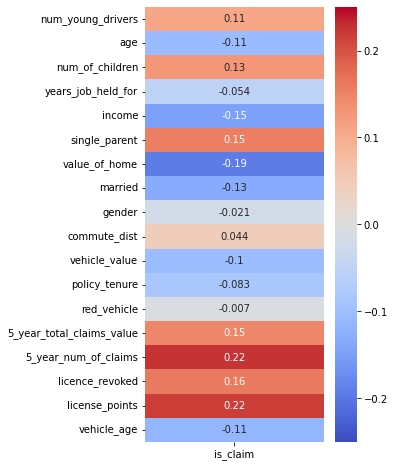

In [37]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix_no_claim = correlation_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

# Observations:

It's important to note that we are not asserting causation; rather, we are exploring potential factors that could explain the observed correlations.

Some features exhibit a significantly stronger positive correlation than others, which might be expected. These include:
- 5_year_num_of_claims: If a person has previously made claims, it's reasonable to speculate they may be more likely to file claims in the future.
- License points: Accumulating points on your driving record could indicate poor driving behavior, which may increase the likelihood of being involved in an accident.
- License revoked: Having one's license revoked typically indicates a history of repeated or serious driving offenses, potentially reflecting poor driving habits.

On the other hand, some features show stronger negative correlations, such as:
- Home value: This feature exhibits a stronger negative relationship with the target variable.

Lastly, some features show negligible correlation:
- Commute distance, red vehicle, and gender: These variables show very weak correlations with the target variable. Given their minimal contribution, it might be beneficial to exclude them from the model to streamline the feature set and reduce model complexity.

# DATA CLEANING AND PRE-PROCESSING

We will start by eliminating red vehicle variable as it shows almost no correlation with the target.

In [39]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

In [40]:
# Check how many missing values there are in each feature
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

There is a fairly significant number of missing values. We will need to deal with these when developing the data pipeline. As there are quite a lot of missing values, and many of which are numerical, simple imputation like median or mean may be too naive. Instead, let's impute using KNN for more advanced imputation.

In [41]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [42]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

Now we compare how the knn imputer has worked and has it actualluy replaced any NaN values

In [44]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [45]:
num_test_data_imputed.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0


We can see that there have been changes in the imputed dataframe.

For Categorical Values, we will use a simple imputer with "most_frequent" which will work as good as any.

In [46]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

Now we will check for categorical columns for changes made after imputation

In [47]:
# Get numerical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


In [48]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


We can now join the numerical and categorical data following imputation, to create the complete DataFrame.

In [49]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [50]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

We can see we now have no missing values in any of the features.

# Categorical Feature Encoding

We now need to consider how we will encode the categorical features so that they can be used with machine learning algorithms. Let's start by looking at the number of unqiue values each categorical feature has, so we can decide the best encoding method for each.

In [51]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

Description of categorical column: 
- Single parent, Married, Gender, Type of use, Red vehicle, License revoked, Address type: These features have 2 distinct values, so binary encoding is appropriate.
- Highest education: With 5 ordered categories, ordinal encoding should be used to capture the ranking.
- Occupation: This feature has 8 categories with no inherent order, making one-hot encoding the best choice.
- Vehicle type: With 6 unordered categories, one-hot encoding is suitable for this feature.

In [52]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [54]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-host encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [55]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

In [56]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Why Ordinal was better choice than label encoder?

- Label Encoding typically assigns an integer to each category without considering the order, which might not be appropriate for features like Highest education, where the categories have a clear ranking. Label encoding could end up creating arbitrary numeric relationships (e.g., High School = 0, Bachelor = 1, Master = 2, Doctorate = 3), but it may not explicitly capture the ordinal nature of the categories in a way that is understood by all models.

In [58]:
# Join numerical and categorical data
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [59]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Dummy Variable Trap:

Since we’ve applied one-hot encoding to some of the features, we are likely to encounter the 'dummy variable trap.' This happens when one of the dummy variables becomes redundant, creating perfect multicollinearity. In other words, knowing the values of all but one of the features allows you to perfectly predict the remaining one. To detect multicollinearity, we can use the Variance Inflation Factor (VIF).

In [60]:
# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


How to handle the Dummy Variable Trap?

- It is evident that the features that were one-hot encoded (such as occupation and vehicle type) exhibit perfect multicollinearity. The simplest way to resolve this issue is by removing one of the dummy variables from the encoded data. This approach is commonly known as dropping the 'reference category' or 'baseline category.'

In [61]:
X_train_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

In [62]:
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,80.124998
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


# Model Selection (Classification)

We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.

The tests here will be brief without any deeper optimisation.

In [85]:
# Define the classifiers to test
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('Linear SVM', LinearSVC(random_state=0, tol=1e-5)),
    ('Nearest Neighbors', KNeighborsClassifier(3)),
    ('RBF SVM', SVC(random_state=0, gamma=2, C=1)),
    ('Decision Tree', DecisionTreeClassifier(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestClassifier(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('Neural Net', MLPClassifier(random_state=0, alpha=1, max_iter=1000)),
    ('AdaBoost', AdaBoostClassifier(random_state=0)),
    ('Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('XGBoost', XGBClassifier(random_state=0)),
    ('GBM Classifier', GradientBoostingClassifier(random_state=0)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

We'll use cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.

In [ ]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in classifiers:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf)#,error_score="raise")
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

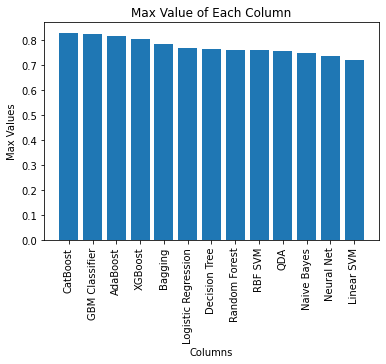

In [104]:
max_values = cv_scores_df.max().sort_values(ascending= False)
max_values_dict = max_values.to_dict()

# Create a bar plot
plt.bar(max_values_dict.keys(), max_values_dict.values())
plt.xlabel('Columns')
plt.ylabel('Max Values')
plt.title('Max Value of Each Column')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

Let's now plot the results of each test, for each classifyer with a boxplot so we can compare the models.

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

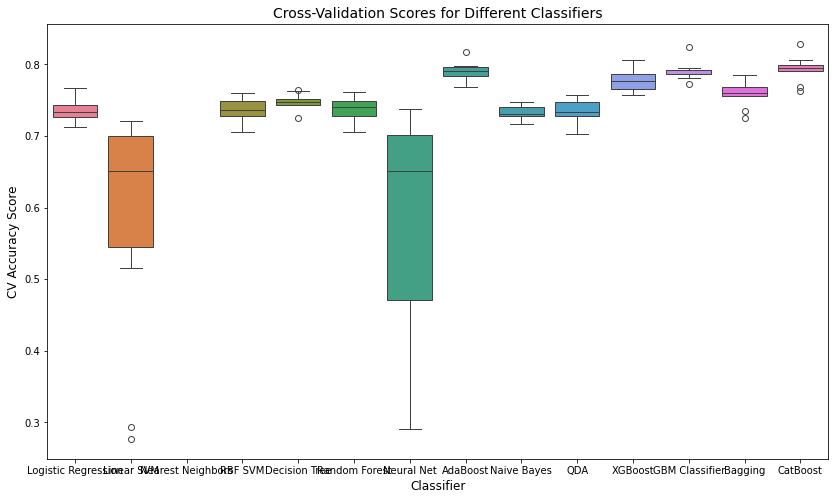

In [88]:
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)

From the above, we can see clearly that all 3 of the GBM, CatBoost and AdaBoost Classifiers performed similarly. XGBoost is the runner up after that, these results are enough for us to decide to proceed with a GBM variant.

Although GBM performed marginally better here, we'll use XGBoost since it's the more advanced, more tuneable algorithm.

# FEATURE ENGINEERING

Let's take a look at the distributions of our numerical features to see if we could potentially improve the performance of our models by transforming any existing features. First we'll create histograms for each of the numerical features.

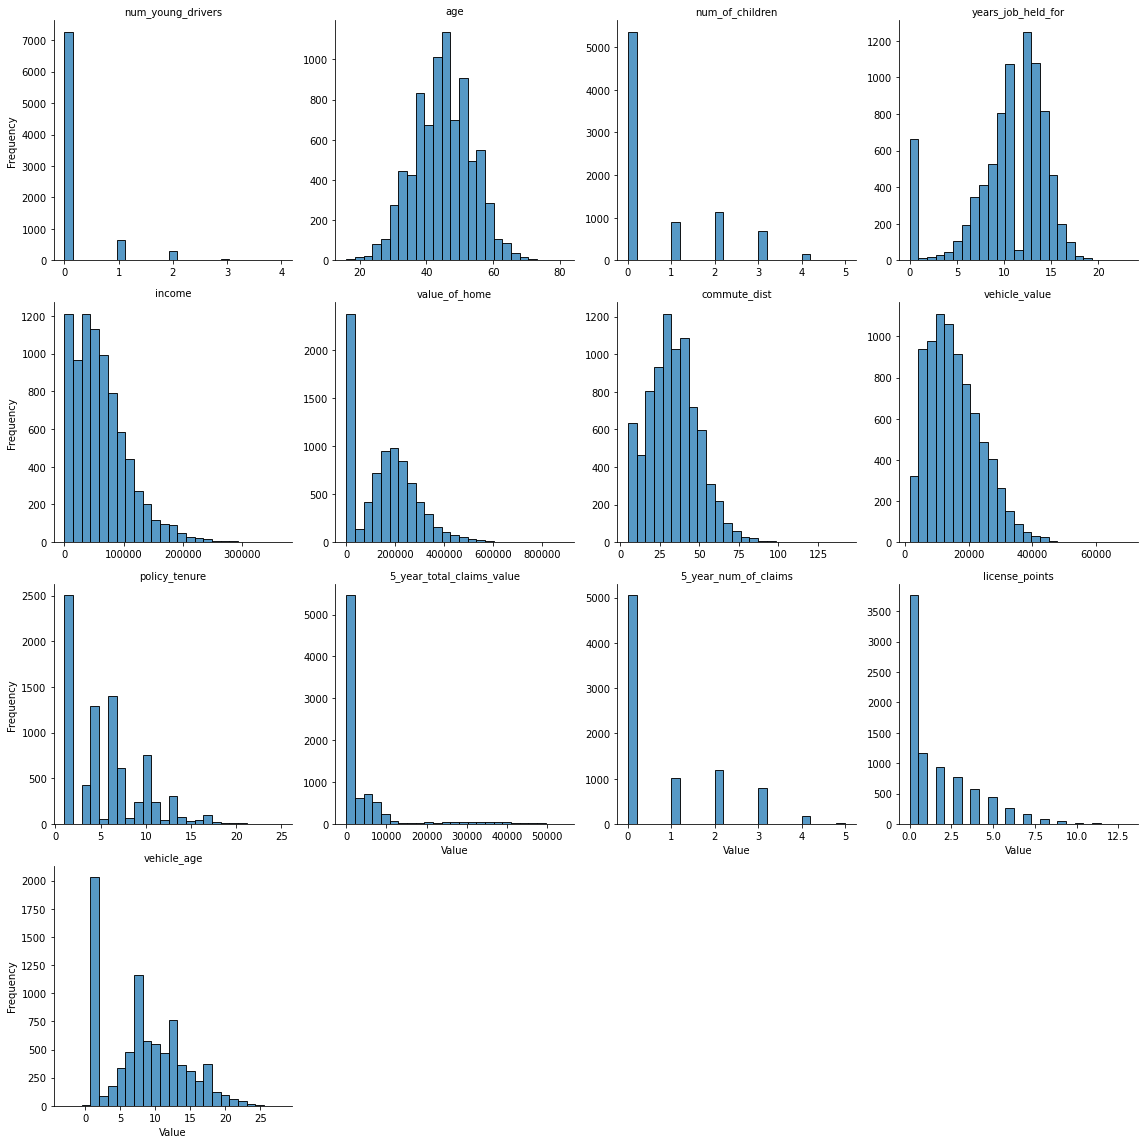

In [105]:
# Melt the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

We can see that some of the features have a right skew. We can try to log transform these features to reduce the skew.

In [106]:
# Define features we right skew
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

We can now look at the distributions again to see if the log transform was effective at reducing the right skews.

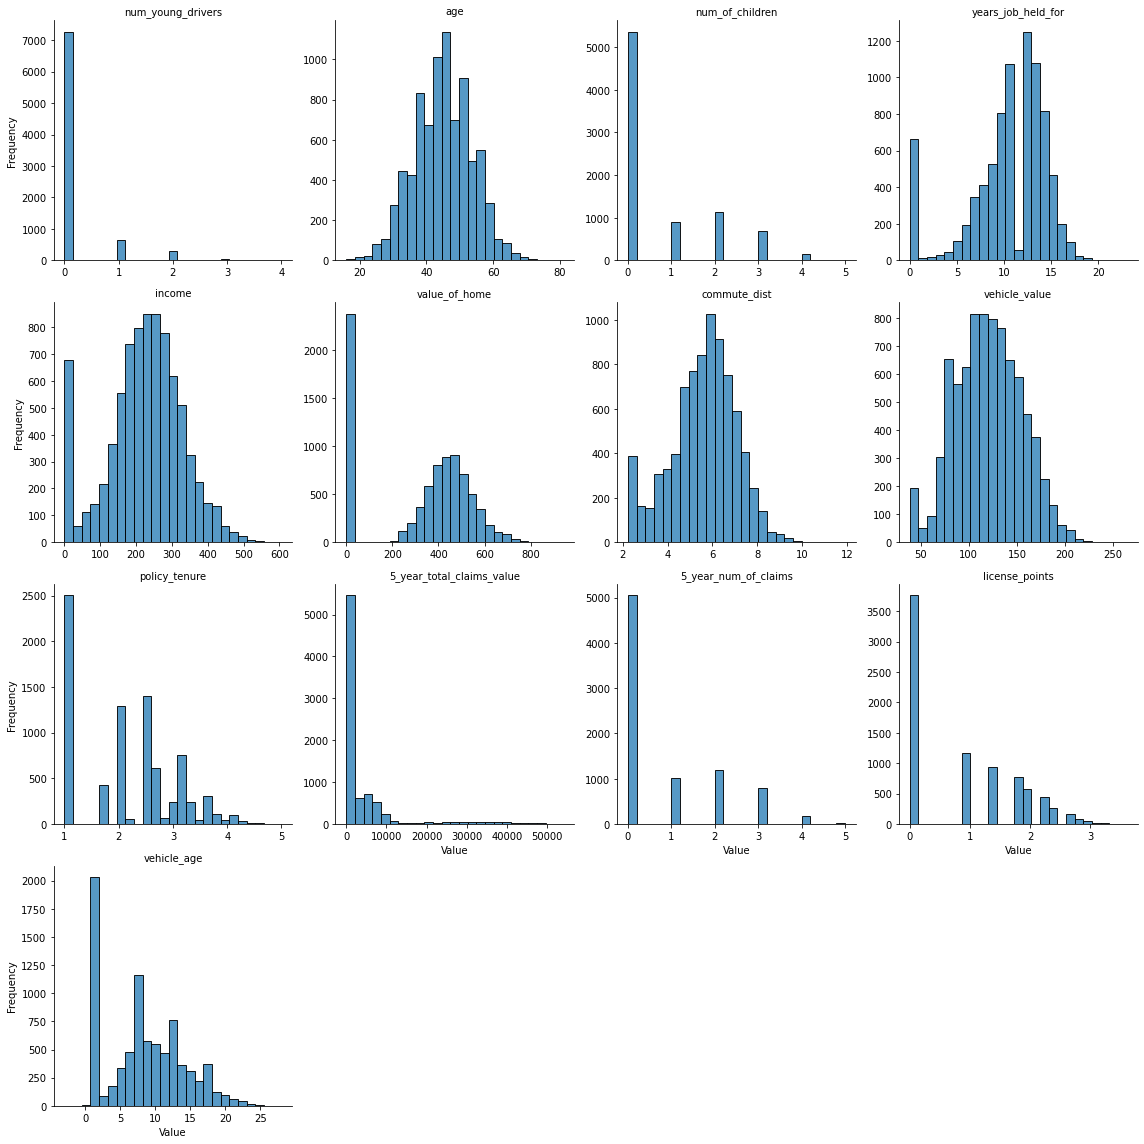

In [107]:
melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

The skews have been reduced, so let's now see if it has improved the performance of the XGBoost model.

In [108]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.7777912621359223
CV score with log transform: 0.7777912621359223


It's clear that our log transform made no impact in improving the base score. This is often to be expected with boosting models, as they are less sensitive to skew and scale than some models. However, it may be beneficial to our regression model later so we'll keep it.

# IMPACT OF FEATURE SCALING

Now let's check if scaling our numerical features has any impact on model performance.

In [109]:
# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    # Initialise scaler
    scaler = StandardScaler()
    # Fit scaler to training data
    scaler.fit(data[numeric_features])
    # Transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply the function to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [110]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_scaled.mean()}')

CV score without log transform: 0.7777912621359223
CV score with log transform: 0.7776699029126213


Again, it's clear that the scaling made no impact in improving the base score. However, it may be beneficial to our regression model later so we'll keep it.

# HYPERPARAMETER OPTIMISATION

To cover a larger parameter space, we'll first use RandomisedSearchCV with random values from a defined range. We can then focus in on a smaller range of values with GridSearchCV

In [127]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error', n_jobs=1)

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,  # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=1
)

In [128]:
# Fit the model using RandomizedSearchCV

try:
    random_search.fit(X_train_cleaned, y_train)
    print("Fit completed successfully.")
except Exception as e:
    print(f"Fit failed: {e}")

    
# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Fit completed successfully.
Best parameters found:  {'colsample_bytree': 0.6273965553158464, 'gamma': 0.2595504332730826, 'learning_rate': 0.09479339691584471, 'max_depth': 18, 'min_child_weight': 18, 'n_estimators': 155, 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.9225724049058001}
Best cross-validation score:  0.784224538346349


We've now got the result from the random search. Let's compared the model scores for the default model, and the tuned model:



In [126]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {random_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7777912621359223
XGBoost model score (tuned hyperparamters: 0.7814570476846006


# GRID SEARCH

OK, we now have the best parameter values from our Random Search. As we've reduce the parameter space, we can now use grid search to check parameter combinations within the reduced grid space.

In [132]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [150, 160, 170],
    'max_depth': [17, 18, 19],
    'learning_rate': [0.08, 0.09, 0.1],
    'subsample': [0.85, 0.90, 0.95],
    'colsample_bytree': [0.55, 0.6, 0.65],
    'gamma': [0.2, 0.25, 0.3],
    'min_child_weight': [18],
    'reg_alpha': [10],
    'reg_lambda': [0],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up GridSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=1
)

In [133]:
# Fit the model using RandomizedSearchCV
grid_search.fit(X_train_cleaned, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.65, 'gamma': 0.25, 'learning_rate': 0.08, 'max_depth': 17, 'min_child_weight': 18, 'n_estimators': 160, 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.95}
Best cross-validation score:  0.7888705487472569


We've now got the result from the grid search. Let's compared the model scores for the default model, and the tuned model:

In [134]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7777912621359223
XGBoost model score (tuned hyperparamters: 0.7888705487472569


Great, we saw an improvement of nearly 1%.

# MODEL EVALUATION

Now it is time to evalusate our model with our test dataset

In [160]:
X_test_raw = X_test.copy()

cols_to_drop = [
    'red_vehicle',
]

X_test_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

In [161]:
# Check how many missing values there are in each feature
X_test_raw.isnull().sum()

num_young_drivers              0
age                            2
num_of_children                0
years_job_held_for           115
income                        96
single_parent                  0
value_of_home                113
married                        0
gender                         0
highest_education              0
occupation                   138
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  122
address_type                   0
dtype: int64

In [162]:
num_test_data_imputed = num_knn_impute(X_test_raw, numerical_cols, knn_imputer)

In [163]:
cat_test_data_imputed = cat_simple_imputer(X_test_raw, cat_cols, simple_imputer)

In [164]:
test_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
test_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,53.0,0.0,16.0,90526.0,262538.0,5.0,30810.0,1.0,0.0,0.0,0.0,6.0,No,Yes,M,Bachelors,Professional,Commercial,Panel Truck,No,Highly Rural/ Rural
1,0.0,25.0,3.0,0.0,0.0,0.0,27.0,5950.0,1.0,0.0,0.0,3.0,1.0,No,Yes,F,High School,Student,Commercial,SUV,No,Highly Urban/ Urban
2,0.0,51.0,0.0,9.0,44977.0,70656.0,41.0,6000.0,10.0,8060.0,2.0,6.0,1.0,No,Yes,M,High School,Blue Collar,Commercial,Pickup,No,Highly Urban/ Urban
3,0.0,40.0,1.0,7.0,34512.0,0.0,51.0,8950.0,6.0,4955.0,1.0,7.0,1.0,Yes,No,M,High School,Blue Collar,Commercial,Pickup,No,Highly Urban/ Urban
4,0.0,41.0,0.0,11.5,78834.0,200776.0,15.0,29830.0,1.0,9980.0,1.0,4.0,17.0,No,Yes,M,Masters,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban


In [165]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

In [166]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [167]:
# Join numerical and categorical data
X_test_cleaned = pd.concat([test_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [170]:
X_test_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

In [173]:
# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_cleaned)

In [174]:
f1_score(y_test, y_pred, average='weighted')

0.7808114586248177

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

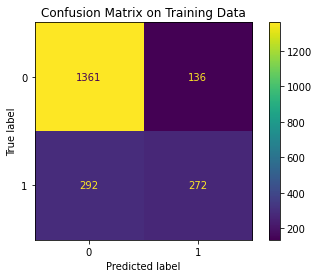

In [175]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')

# Regression

We can now look at the regression part of this project. We want to predict the total value of a claim, assuming a claim has been made. We start by creating the test/train sets, using only records where the claim value > 0.

In [176]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [ ]:
y_reg.columns